# Guiding DIP Early Stopping with DDPM (UNet model with 180 stages)

In [2]:
# import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import cv2
import torch, torch.nn as nn
from tqdm import tqdm
from skimage.metrics import peak_signal_noise_ratio as compare_psnr
from torchvision import models
from torch.nn.functional import relu

%matplotlib inline

In [3]:
# setup
torch.manual_seed(0)
plt.rcParams['toolbar'] = 'none'
plt.ion() # interactive mode
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


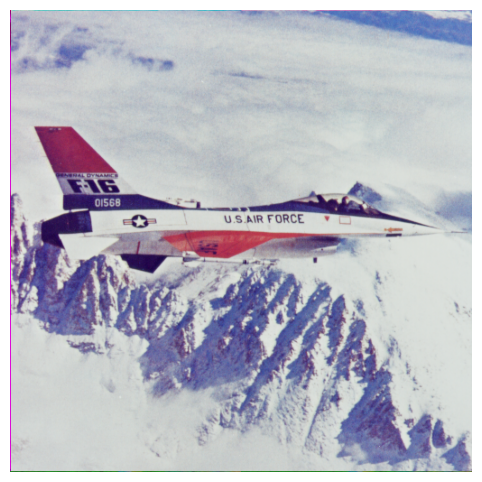

In [4]:
# read the original image
nxd = 512  # pixels in x dimension
img = cv2.imread('/kaggle/input/images/F16_GT.png')
img = cv2.resize(src=img, dsize=(nxd, nxd), interpolation=cv2.INTER_CUBIC)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

fig1, axis1 = plt.subplots(1, 1, figsize=(10,6))
axis1.imshow(img)
axis1.set_axis_off()

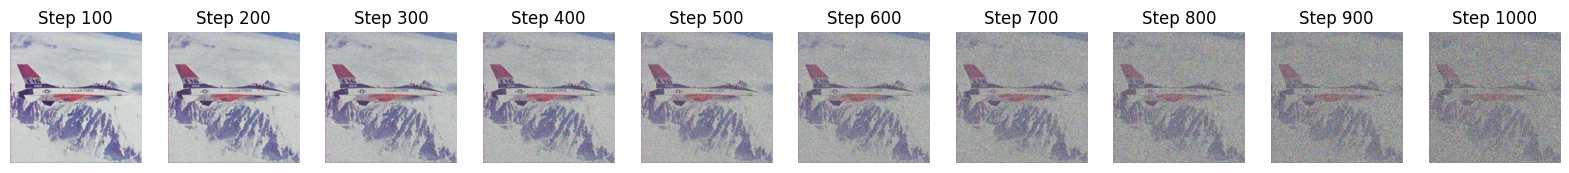

In [5]:
# define forward diffusion function for the DDPM stages
def forward_diffusion(x0, num_steps, beta_start, beta_end):
    betas = np.linspace(beta_start, beta_end, num_steps)
    alphas = 1 - betas
    alphas_cumprod = np.cumprod(alphas)
    
    x_t = []
    x_t.append(x0)
    for t in range(1, num_steps + 1):
        noise = np.random.randint(x0.min(), x0.max(), size=x0.shape)
        alpha_t = alphas_cumprod[t-1]
        x_t_prev = x_t[-1]
        x_t_current = np.sqrt(alpha_t) * x0 + np.sqrt(1 - alpha_t) * noise
        x_t.append(x_t_current)
    
    # Starting from step 100, I set it as Stage 1. Step 110 -> Stage 2, and so on
    output = np.array(x_t)[100::5]
    for i in range(len(output)):
        img_array = output[i]
        img_array = (img_array - img_array.min()) / (img_array.max() - img_array.min())  # Normalize to [0, 1]
        output[i] = img_array
    
    return output, alphas_cumprod

def plot_images(x_t, indices):
    num_images = len(indices)
    fig, axes = plt.subplots(1, num_images, figsize=(20, 12))
    for ax, idx in zip(axes, indices):
        ax.imshow(x_t[idx])
        ax.set_title(f'Step {idx*10+100}')
        ax.axis('off')
    plt.show()

# parameters for forward diffusion
x0 = img
num_steps = 1000
beta_start = 0.0001
beta_end = 0.02
x_t, alphas_cumprod = forward_diffusion(x0, num_steps, beta_start, beta_end)

# plot some stages to check the forward diffusion results
plot_images(x_t, indices=[i for i in range(0, 100, 10)])

In [7]:
# setup double convolution class
class DoubleConv(nn.Module):
    def __init__(self, input_channel, output_channel):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(input_channel, output_channel, kernel_size=3, padding=1),
            nn.BatchNorm2d(output_channel),
            nn.ReLU(),
            nn.Conv2d(output_channel, output_channel, kernel_size=3, padding=1),
            nn.BatchNorm2d(output_channel),
            nn.ReLU()
        )
    
    def forward(self, x):
        return self.conv(x)

# setup UNet class
class UNet(nn.Module):
    def __init__(self, input_channel, output_channel):
        super(UNet, self).__init__()
        
        # Encoder
        self.downconv1 = DoubleConv(input_channel, 64)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.downconv2 = DoubleConv(64, 128)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.downconv3 = DoubleConv(128, 256)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.downconv4 = DoubleConv(256, 512)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2) 

        self.conv5 = DoubleConv(512, 1024)

        # Decoder
        self.upconv1 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.conv6 = DoubleConv(1024, 512)

        self.upconv2 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.conv7 = DoubleConv(512, 256)

        self.upconv3 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.conv8 = DoubleConv(256, 128)

        self.upconv4 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.conv9 = DoubleConv(128, 64)

        # Output layer
        self.outconv = nn.Conv2d(64, output_channel, kernel_size=1)

    def forward(self, x):
        dc1 = self.downconv1(x)
        p1 = self.pool1(dc1)

        dc2 = self.downconv2(p1)
        p2 = self.pool2(dc2)

        dc3 = self.downconv3(p2)
        p3 = self.pool3(dc3)
        
        dc4 = self.downconv4(p3)
        p4 = self.pool4(dc4)
        
        dc5 = self.conv5(p4)
        
        uc6 = self.upconv1(dc5)
        concat6 = torch.cat([uc6, dc4], dim=1)
        c6 = self.conv6(concat6)
        
        uc7 = self.upconv2(c6)
        concat7 = torch.cat([uc7, dc3], dim=1)
        c7 = self.conv7(concat7)
        
        uc8 = self.upconv3(c7)
        concat8 = torch.cat([uc8, dc2], dim=1)
        c8 = self.conv8(concat8)
        
        uc9 = self.upconv4(c8)
        concat9 = torch.cat([uc9, dc1], dim=1)
        c9 = self.conv9(concat9)
        
        c10 = self.outconv(c9)
        #out = nn.Sigmoid()(c10)
        return c10
    
    
unet = UNet(3, 3).to(device)

Text(0.5, 1.0, 'input image 512 x 512')

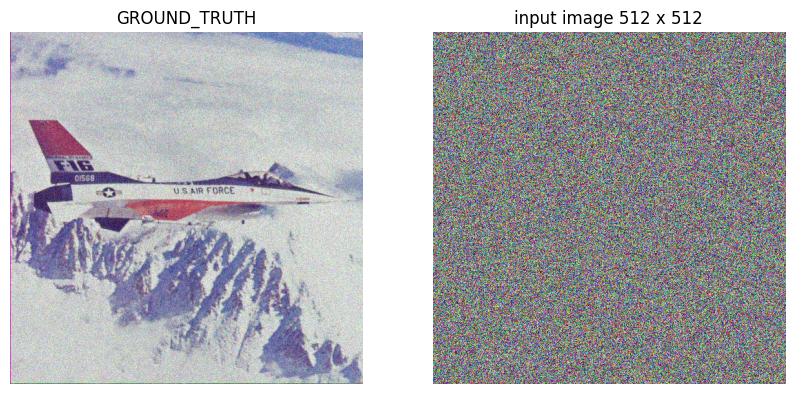

In [8]:
# input image is pure noise
input_image = torch.rand(nxd, nxd, 3).to(device)  

def torch_to_numpy(torch_array):
    return np.squeeze(torch_array.detach().cpu().numpy())
def numpy_to_torch(numpy_array):
    return torch.from_numpy(numpy_array).float()

fig2, axis2 = plt.subplots(1, 2, figsize=(10,6))
# I set step 100 image as my ground truth
axis2[0].imshow(x_t[1])
axis2[0].set_title('GROUND_TRUTH')
axis2[0].set_axis_off()
axis2[1].set_axis_off()
axis2[1].imshow(torch_to_numpy(input_image))
axis2[1].set_title('input image %d x %d' %(nxd, nxd))

In [9]:
# initialize training valiables
optimiser = torch.optim.Adam(unet.parameters(), lr=1e-4)
train_loss = []
psnr_list = []
psnr_list_at_each_stage = []
output_images = []
output_psnr = [] # records max psnr for each stage

print("Total stages:", len(x_t))

Total stages: 181


In [10]:
mse_fn = nn.MSELoss().to(device)

# training process starting from heavily corrupted images
for ind in range(len(x_t)-1, 1, -1):
    psnr_list = []
    cnt = 0
    for ep in tqdm(range(30)):
        optimiser.zero_grad()
        output_image = unet(input_image.unsqueeze(0).permute(0, 3, 1, 2))
        output_image = output_image.squeeze(0).permute(1, 2, 0)
        loss = mse_fn(numpy_to_torch(x_t[ind]).to(device), output_image)
    
        train_loss.append(loss.item())
        loss.backward() # find gradients
        optimiser.step() # does the update

        psnr = compare_psnr(torch_to_numpy(output_image), x_t[1], data_range=x_t[1].max())
        
        # early stop the stage when psnr value doesn't increase for 3 consecutive times
        if(ep > 1 and psnr.item() < psnr_list[-1]):
            cnt += 1
        psnr_list.append(psnr.item())
        if(cnt > 3):
            break
    
    print(ind)
    print(loss.item())
    output_images.append(output_image)
    psnr_list_at_each_stage.append(psnr_list)
    output_psnr.append(max(psnr_list))

100%|██████████| 30/30 [00:10<00:00,  2.97it/s]


180
0.5483307242393494


100%|██████████| 30/30 [00:07<00:00,  3.84it/s]


179
0.41793644428253174


100%|██████████| 30/30 [00:07<00:00,  3.80it/s]


178
0.3244973421096802


100%|██████████| 30/30 [00:07<00:00,  3.79it/s]


177
0.25473102927207947


100%|██████████| 30/30 [00:07<00:00,  3.77it/s]


176
0.20210155844688416


100%|██████████| 30/30 [00:08<00:00,  3.74it/s]


175
0.16115811467170715


100%|██████████| 30/30 [00:08<00:00,  3.71it/s]


174
0.09056516736745834


 73%|███████▎  | 22/30 [00:06<00:02,  3.52it/s]


173
0.057564981281757355


 40%|████      | 12/30 [00:03<00:05,  3.39it/s]


172
0.06889575719833374


 47%|████▋     | 14/30 [00:04<00:04,  3.41it/s]


171
0.06518711149692535


 33%|███▎      | 10/30 [00:03<00:06,  3.31it/s]


170
0.07294648885726929


 33%|███▎      | 10/30 [00:03<00:06,  3.30it/s]


169
0.07269290089607239


 37%|███▋      | 11/30 [00:03<00:05,  3.31it/s]


168
0.07117372751235962


 37%|███▋      | 11/30 [00:03<00:05,  3.31it/s]


167
0.07142314314842224


 37%|███▋      | 11/30 [00:03<00:05,  3.30it/s]


166
0.0714530497789383


 40%|████      | 12/30 [00:03<00:05,  3.31it/s]


165
0.0699339359998703


 33%|███▎      | 10/30 [00:03<00:06,  3.25it/s]


164
0.07396507263183594


 30%|███       | 9/30 [00:02<00:06,  3.20it/s]


163
0.07559049129486084


 37%|███▋      | 11/30 [00:03<00:05,  3.26it/s]


162
0.07239751517772675


 40%|████      | 12/30 [00:03<00:05,  3.27it/s]


161
0.07131702452898026


 37%|███▋      | 11/30 [00:03<00:05,  3.25it/s]


160
0.07289259880781174


 43%|████▎     | 13/30 [00:03<00:05,  3.29it/s]


159
0.0702512115240097


 40%|████      | 12/30 [00:03<00:05,  3.27it/s]


158
0.07194425910711288


 40%|████      | 12/30 [00:03<00:05,  3.29it/s]


157
0.07210004329681396


 40%|████      | 12/30 [00:03<00:05,  3.30it/s]


156
0.07232275605201721


 40%|████      | 12/30 [00:03<00:05,  3.30it/s]


155
0.0726967379450798


 43%|████▎     | 13/30 [00:03<00:05,  3.33it/s]


154
0.07160075753927231


 43%|████▎     | 13/30 [00:03<00:05,  3.33it/s]


153
0.07201658934354782


 43%|████▎     | 13/30 [00:03<00:05,  3.34it/s]


152
0.072113998234272


 50%|█████     | 15/30 [00:04<00:04,  3.38it/s]


151
0.07083886116743088


 50%|█████     | 15/30 [00:04<00:04,  3.38it/s]


150
0.07089609652757645


 40%|████      | 12/30 [00:03<00:05,  3.33it/s]


149
0.07337987422943115


 53%|█████▎    | 16/30 [00:04<00:04,  3.39it/s]


148
0.07050442695617676


 23%|██▎       | 7/30 [00:02<00:07,  3.16it/s]


147
0.07831352204084396


 83%|████████▎ | 25/30 [00:07<00:01,  3.46it/s]


146
0.06582057476043701


 23%|██▎       | 7/30 [00:02<00:07,  3.16it/s]


145
0.0780213475227356


 57%|█████▋    | 17/30 [00:04<00:03,  3.40it/s]


144
0.07058721035718918


 17%|█▋        | 5/30 [00:01<00:08,  3.01it/s]


143
0.07918071746826172


 70%|███████   | 21/30 [00:06<00:02,  3.43it/s]


142
0.06856562942266464


 20%|██        | 6/30 [00:01<00:07,  3.07it/s]


141
0.07787413895130157


 67%|██████▋   | 20/30 [00:05<00:02,  3.41it/s]


140
0.06886501610279083


 17%|█▋        | 5/30 [00:01<00:08,  2.98it/s]


139
0.07854749262332916


 73%|███████▎  | 22/30 [00:06<00:02,  3.42it/s]


138
0.06749784201383591


 20%|██        | 6/30 [00:01<00:07,  3.06it/s]


137
0.07679979503154755


 73%|███████▎  | 22/30 [00:06<00:02,  3.42it/s]


136
0.06681863963603973


 23%|██▎       | 7/30 [00:02<00:07,  3.13it/s]


135
0.0753258466720581


 67%|██████▋   | 20/30 [00:05<00:02,  3.41it/s]


134
0.06728168576955795


 23%|██▎       | 7/30 [00:02<00:07,  3.13it/s]


133
0.07485296577215195


 50%|█████     | 15/30 [00:04<00:04,  3.36it/s]


132
0.06950074434280396


 47%|████▋     | 14/30 [00:04<00:04,  3.34it/s]


131
0.06975454092025757


 40%|████      | 12/30 [00:03<00:05,  3.30it/s]


130
0.0706477165222168


 43%|████▎     | 13/30 [00:03<00:05,  3.33it/s]


129
0.0699787586927414


 43%|████▎     | 13/30 [00:03<00:05,  3.33it/s]


128
0.06998098641633987


 33%|███▎      | 10/30 [00:03<00:06,  3.26it/s]


127
0.07152505964040756


 47%|████▋     | 14/30 [00:04<00:04,  3.35it/s]


126
0.06966619938611984


 33%|███▎      | 10/30 [00:03<00:06,  3.27it/s]


125
0.07097934931516647


 47%|████▋     | 14/30 [00:04<00:04,  3.35it/s]


124
0.06915341317653656


 20%|██        | 6/30 [00:01<00:07,  3.08it/s]


123
0.07257888466119766


 90%|█████████ | 27/30 [00:07<00:00,  3.46it/s]


122
0.0635301023721695


 17%|█▋        | 5/30 [00:01<00:08,  2.99it/s]


121
0.07229892909526825


 57%|█████▋    | 17/30 [00:05<00:03,  3.39it/s]


120
0.06562121212482452


 20%|██        | 6/30 [00:01<00:07,  3.07it/s]


119
0.07071032375097275


 47%|████▋     | 14/30 [00:04<00:04,  3.36it/s]


118
0.0665709599852562


 37%|███▋      | 11/30 [00:03<00:05,  3.29it/s]


117
0.06727931648492813


 77%|███████▋  | 23/30 [00:06<00:02,  3.44it/s]


116
0.06202429533004761


 20%|██        | 6/30 [00:01<00:07,  3.08it/s]


115
0.06895353645086288


 40%|████      | 12/30 [00:03<00:05,  3.31it/s]


114
0.06588351726531982


 40%|████      | 12/30 [00:03<00:05,  3.31it/s]


113
0.065207839012146


 30%|███       | 9/30 [00:02<00:06,  3.23it/s]


112
0.06617636978626251


 70%|███████   | 21/30 [00:06<00:02,  3.43it/s]


111
0.061036743223667145


 23%|██▎       | 7/30 [00:02<00:07,  3.14it/s]


110
0.06609460711479187


 63%|██████▎   | 19/30 [00:05<00:03,  3.40it/s]


109
0.0603136345744133


 37%|███▋      | 11/30 [00:03<00:05,  3.29it/s]


108
0.06305710226297379


 40%|████      | 12/30 [00:03<00:05,  3.31it/s]


107
0.06198466941714287


 40%|████      | 12/30 [00:03<00:05,  3.31it/s]


106
0.06197460740804672


 43%|████▎     | 13/30 [00:03<00:05,  3.33it/s]


105
0.06091843172907829


 40%|████      | 12/30 [00:03<00:05,  3.31it/s]


104
0.06085836514830589


 43%|████▎     | 13/30 [00:03<00:05,  3.33it/s]


103
0.06016802787780762


 33%|███▎      | 10/30 [00:03<00:06,  3.26it/s]


102
0.061461519449949265


 40%|████      | 12/30 [00:03<00:05,  3.31it/s]


101
0.05956905335187912


 40%|████      | 12/30 [00:03<00:05,  3.31it/s]


100
0.05946441739797592


 43%|████▎     | 13/30 [00:03<00:05,  3.33it/s]


99
0.05853835865855217


 40%|████      | 12/30 [00:03<00:05,  3.31it/s]


98
0.058549679815769196


 43%|████▎     | 13/30 [00:03<00:05,  3.33it/s]


97
0.057526275515556335


 40%|████      | 12/30 [00:03<00:05,  3.31it/s]


96
0.057451169937849045


 43%|████▎     | 13/30 [00:03<00:05,  3.33it/s]


95
0.05658983439207077


 40%|████      | 12/30 [00:03<00:05,  3.31it/s]


94
0.05624592304229736


 63%|██████▎   | 19/30 [00:05<00:03,  3.40it/s]


93
0.05337967723608017


 23%|██▎       | 7/30 [00:02<00:07,  3.14it/s]


92
0.056502267718315125


 73%|███████▎  | 22/30 [00:06<00:02,  3.43it/s]


91
0.0513593964278698


 30%|███       | 9/30 [00:02<00:06,  3.23it/s]


90
0.055190324783325195


 37%|███▋      | 11/30 [00:03<00:05,  3.29it/s]


89
0.053230397403240204


 40%|████      | 12/30 [00:03<00:05,  3.31it/s]


88
0.0522594228386879


 43%|████▎     | 13/30 [00:03<00:05,  3.33it/s]


87
0.05178282782435417


 33%|███▎      | 10/30 [00:03<00:06,  3.27it/s]


86
0.05183860659599304


 43%|████▎     | 13/30 [00:03<00:05,  3.33it/s]


85
0.05109386891126633


 40%|████      | 12/30 [00:03<00:05,  3.31it/s]


84
0.05034378916025162


 50%|█████     | 15/30 [00:04<00:04,  3.36it/s]


83
0.04915294051170349


 53%|█████▎    | 16/30 [00:04<00:04,  3.38it/s]


82
0.04806683585047722


 40%|████      | 12/30 [00:03<00:05,  3.31it/s]


81
0.048564232885837555


 43%|████▎     | 13/30 [00:03<00:05,  3.32it/s]


80
0.04776173084974289


 43%|████▎     | 13/30 [00:03<00:05,  3.33it/s]


79
0.04710705578327179


 40%|████      | 12/30 [00:03<00:05,  3.31it/s]


78
0.04678281396627426


 43%|████▎     | 13/30 [00:03<00:05,  3.33it/s]


77
0.04604518041014671


 53%|█████▎    | 16/30 [00:04<00:04,  3.37it/s]


76
0.04492640122771263


 33%|███▎      | 10/30 [00:03<00:06,  3.26it/s]


75
0.04591779410839081


 33%|███▎      | 10/30 [00:03<00:06,  3.26it/s]


74
0.045143336057662964


 40%|████      | 12/30 [00:03<00:05,  3.31it/s]


73
0.044441573321819305


 40%|████      | 12/30 [00:03<00:05,  3.30it/s]


72
0.04380133002996445


 40%|████      | 12/30 [00:03<00:05,  3.31it/s]


71
0.04307982325553894


 37%|███▋      | 11/30 [00:03<00:05,  3.29it/s]


70
0.04315242916345596


 40%|████      | 12/30 [00:03<00:05,  3.31it/s]


69
0.04180051013827324


 40%|████      | 12/30 [00:03<00:05,  3.31it/s]


68
0.04107154905796051


 43%|████▎     | 13/30 [00:03<00:05,  3.33it/s]


67
0.04047016426920891


 50%|█████     | 15/30 [00:04<00:04,  3.36it/s]


66
0.03971339017152786


 40%|████      | 12/30 [00:03<00:05,  3.31it/s]


65
0.039436377584934235


 43%|████▎     | 13/30 [00:03<00:05,  3.32it/s]


64
0.038447313010692596


 47%|████▋     | 14/30 [00:04<00:04,  3.35it/s]


63
0.03792274743318558


 50%|█████     | 15/30 [00:04<00:04,  3.36it/s]


62
0.03703989088535309


 50%|█████     | 15/30 [00:04<00:04,  3.36it/s]


61
0.03664395958185196


 20%|██        | 6/30 [00:01<00:07,  3.08it/s]


60
0.03807574510574341


 50%|█████     | 15/30 [00:04<00:04,  3.36it/s]


59
0.035581380128860474


 87%|████████▋ | 26/30 [00:07<00:01,  3.45it/s]


58
0.03300280496478081


 27%|██▋       | 8/30 [00:02<00:06,  3.19it/s]


57
0.035874366760253906


 23%|██▎       | 7/30 [00:02<00:07,  3.14it/s]


56
0.03577124699950218


 37%|███▋      | 11/30 [00:03<00:05,  3.29it/s]


55
0.03444482013583183


 30%|███       | 9/30 [00:02<00:06,  3.22it/s]


54
0.033882733434438705


 37%|███▋      | 11/30 [00:03<00:05,  3.29it/s]


53
0.03290243446826935


 43%|████▎     | 13/30 [00:03<00:05,  3.33it/s]


52
0.03234565258026123


 43%|████▎     | 13/30 [00:03<00:05,  3.33it/s]


51
0.03171402961015701


 40%|████      | 12/30 [00:03<00:05,  3.31it/s]


50
0.031210266053676605


 43%|████▎     | 13/30 [00:03<00:05,  3.33it/s]


49
0.030511435121297836


 43%|████▎     | 13/30 [00:03<00:05,  3.32it/s]


48
0.029975395649671555


 40%|████      | 12/30 [00:03<00:05,  3.31it/s]


47
0.02940724417567253


 40%|████      | 12/30 [00:03<00:05,  3.31it/s]


46
0.028680454939603806


 47%|████▋     | 14/30 [00:04<00:04,  3.36it/s]


45
0.02825687639415264


 40%|████      | 12/30 [00:03<00:05,  3.31it/s]


44
0.027695227414369583


 40%|████      | 12/30 [00:03<00:05,  3.31it/s]


43
0.0270700603723526


 47%|████▋     | 14/30 [00:04<00:04,  3.34it/s]


42
0.026709318161010742


 50%|█████     | 15/30 [00:04<00:04,  3.37it/s]


41
0.025835497304797173


 40%|████      | 12/30 [00:03<00:05,  3.31it/s]


40
0.02530050277709961


 47%|████▋     | 14/30 [00:04<00:04,  3.35it/s]


39
0.02450188808143139


 47%|████▋     | 14/30 [00:04<00:04,  3.35it/s]


38
0.024062637239694595


 47%|████▋     | 14/30 [00:04<00:04,  3.35it/s]


37
0.02374071255326271


 47%|████▋     | 14/30 [00:04<00:04,  3.35it/s]


36
0.02324865013360977


 47%|████▋     | 14/30 [00:04<00:04,  3.35it/s]


35
0.022560715675354004


 43%|████▎     | 13/30 [00:03<00:05,  3.33it/s]


34
0.021901121363043785


 47%|████▋     | 14/30 [00:04<00:04,  3.35it/s]


33
0.021613027900457382


 50%|█████     | 15/30 [00:04<00:04,  3.36it/s]


32
0.021065881475806236


 47%|████▋     | 14/30 [00:04<00:04,  3.35it/s]


31
0.020528143271803856


 17%|█▋        | 5/30 [00:01<00:08,  3.00it/s]


30
0.02049415372312069


 50%|█████     | 15/30 [00:04<00:04,  3.36it/s]


29
0.019470028579235077


 23%|██▎       | 7/30 [00:02<00:07,  3.14it/s]


28
0.019153423607349396


 43%|████▎     | 13/30 [00:03<00:05,  3.33it/s]


27
0.01835731416940689


 20%|██        | 6/30 [00:01<00:07,  3.07it/s]


26
0.018114689737558365


 43%|████▎     | 13/30 [00:03<00:05,  3.33it/s]


25
0.01763208955526352


 17%|█▋        | 5/30 [00:01<00:08,  2.99it/s]


24
0.017074428498744965


 50%|█████     | 15/30 [00:04<00:04,  3.36it/s]


23
0.016436530277132988


 20%|██        | 6/30 [00:01<00:07,  3.07it/s]


22
0.01618342660367489


 50%|█████     | 15/30 [00:04<00:04,  3.36it/s]


21
0.015465280041098595


 57%|█████▋    | 17/30 [00:05<00:03,  3.39it/s]


20
0.014595533721148968


 50%|█████     | 15/30 [00:04<00:04,  3.36it/s]


19
0.01418359111994505


 53%|█████▎    | 16/30 [00:04<00:04,  3.37it/s]


18
0.0136713907122612


 50%|█████     | 15/30 [00:04<00:04,  3.36it/s]


17
0.013285396620631218


 50%|█████     | 15/30 [00:04<00:04,  3.36it/s]


16
0.012714512646198273


 33%|███▎      | 10/30 [00:03<00:06,  3.26it/s]


15
0.012364978902041912


 47%|████▋     | 14/30 [00:04<00:04,  3.34it/s]


14
0.011776446364820004


 53%|█████▎    | 16/30 [00:04<00:04,  3.38it/s]


13
0.01119566336274147


 47%|████▋     | 14/30 [00:04<00:04,  3.35it/s]


12
0.010759145021438599


 47%|████▋     | 14/30 [00:04<00:04,  3.34it/s]


11
0.010237742215394974


 53%|█████▎    | 16/30 [00:04<00:04,  3.37it/s]


10
0.009950421750545502


 33%|███▎      | 10/30 [00:03<00:06,  3.26it/s]


9
0.009529405273497105


 50%|█████     | 15/30 [00:04<00:04,  3.36it/s]


8
0.009013271890580654


 47%|████▋     | 14/30 [00:04<00:04,  3.34it/s]


7
0.008476532995700836


 40%|████      | 12/30 [00:03<00:05,  3.31it/s]


6
0.008131138049066067


 43%|████▎     | 13/30 [00:03<00:05,  3.33it/s]


5
0.0076503753662109375


 57%|█████▋    | 17/30 [00:05<00:03,  3.39it/s]


4
0.007296876981854439


 43%|████▎     | 13/30 [00:03<00:05,  3.33it/s]


3
0.006822235882282257


 40%|████      | 12/30 [00:03<00:05,  3.31it/s]

2
0.006403729319572449


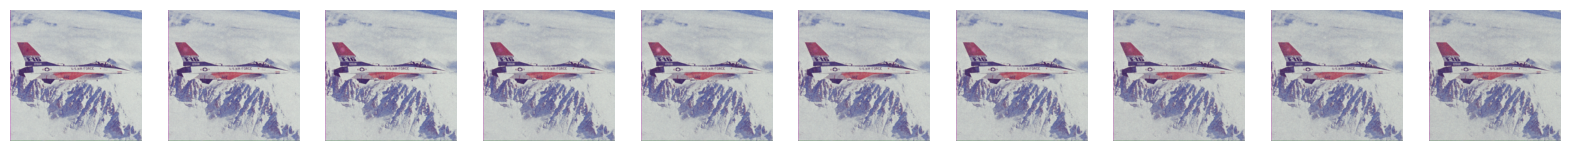

In [11]:
# plot the result images from last 10 stages
fig1, axis1 = plt.subplots(1, 10, figsize=(20,12))
for i in range(1, 11):
    axis1[i-1].set_axis_off()
    axis1[i-1].imshow(torch_to_numpy(output_images[i*-1]))

Text(0.5, 1.0, 'Output Image')

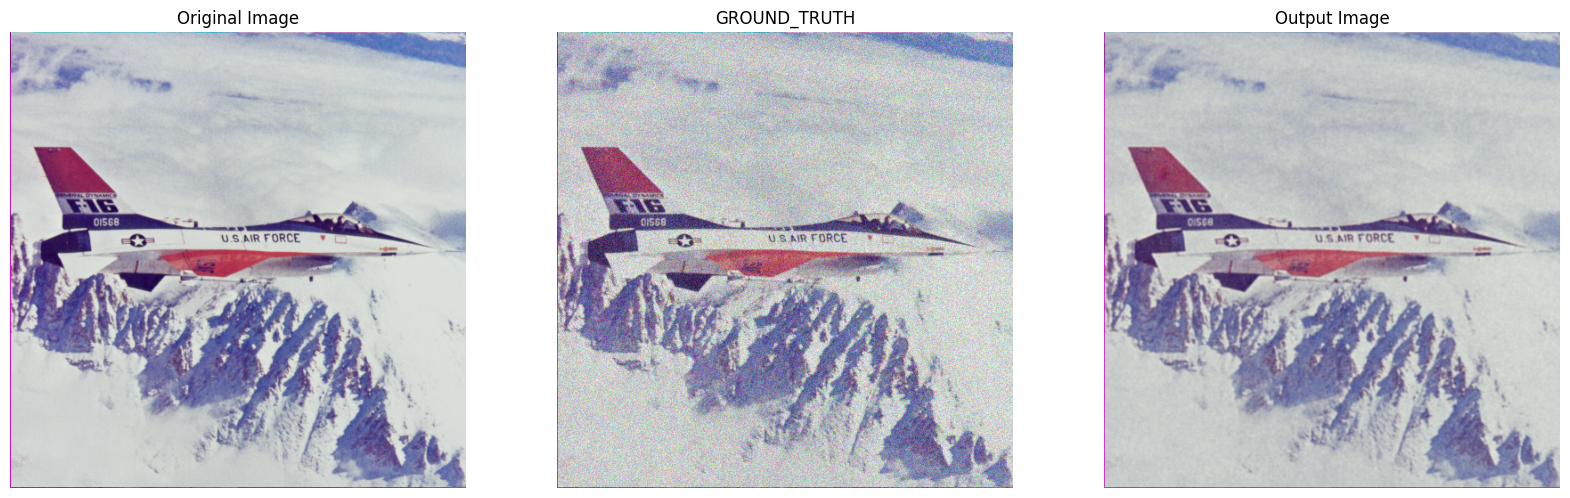

In [12]:
fig1, axis1 = plt.subplots(1, 3, figsize=(20,12))
axis1[0].imshow(img)
axis1[0].set_axis_off()
axis1[0].set_title('Original Image')
axis1[1].imshow(x_t[1])
axis1[1].set_axis_off()
axis1[1].set_title('GROUND_TRUTH')
axis1[2].imshow(torch_to_numpy(output_images[-1]))
axis1[2].set_axis_off()
axis1[2].set_title('Output Image')

Text(0, 0.5, 'MSE')

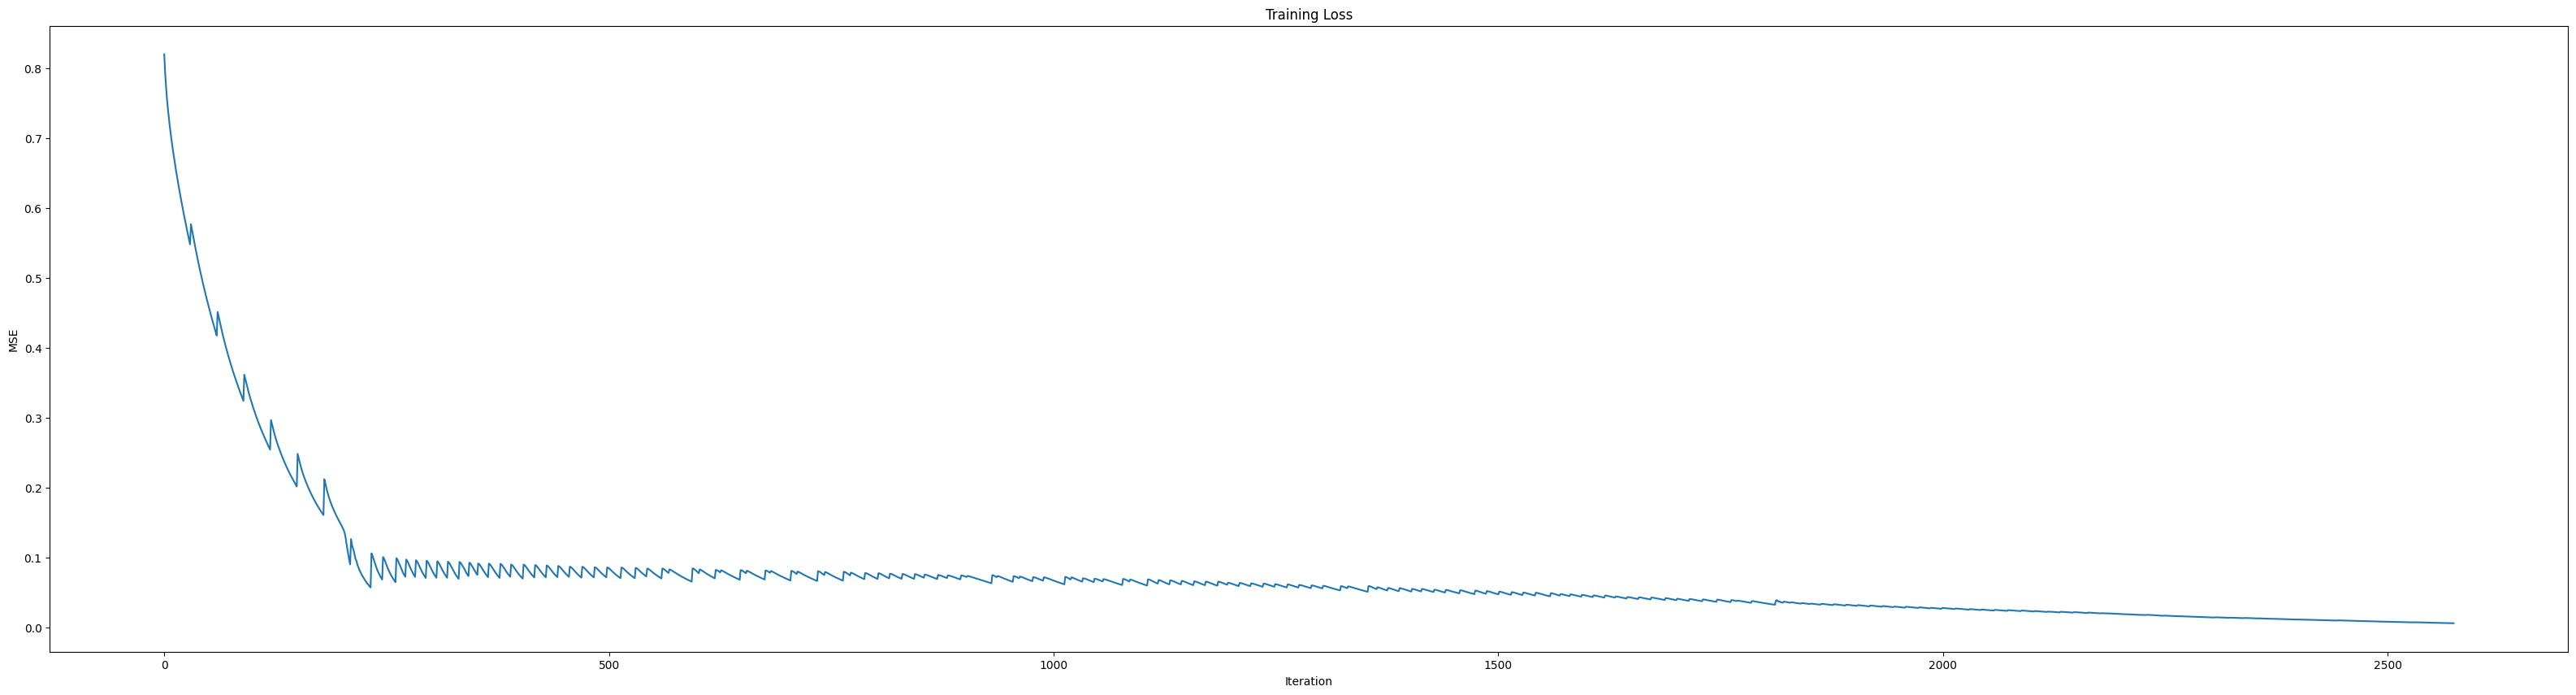

In [13]:
fig1, axis1 = plt.subplots(1, 1, figsize=(40, 10))
axis1.plot(train_loss)
axis1.set_title('Training Loss')
plt.xlabel("Iteration")
plt.ylabel("MSE")

Text(0, 0.5, 'PSNR')

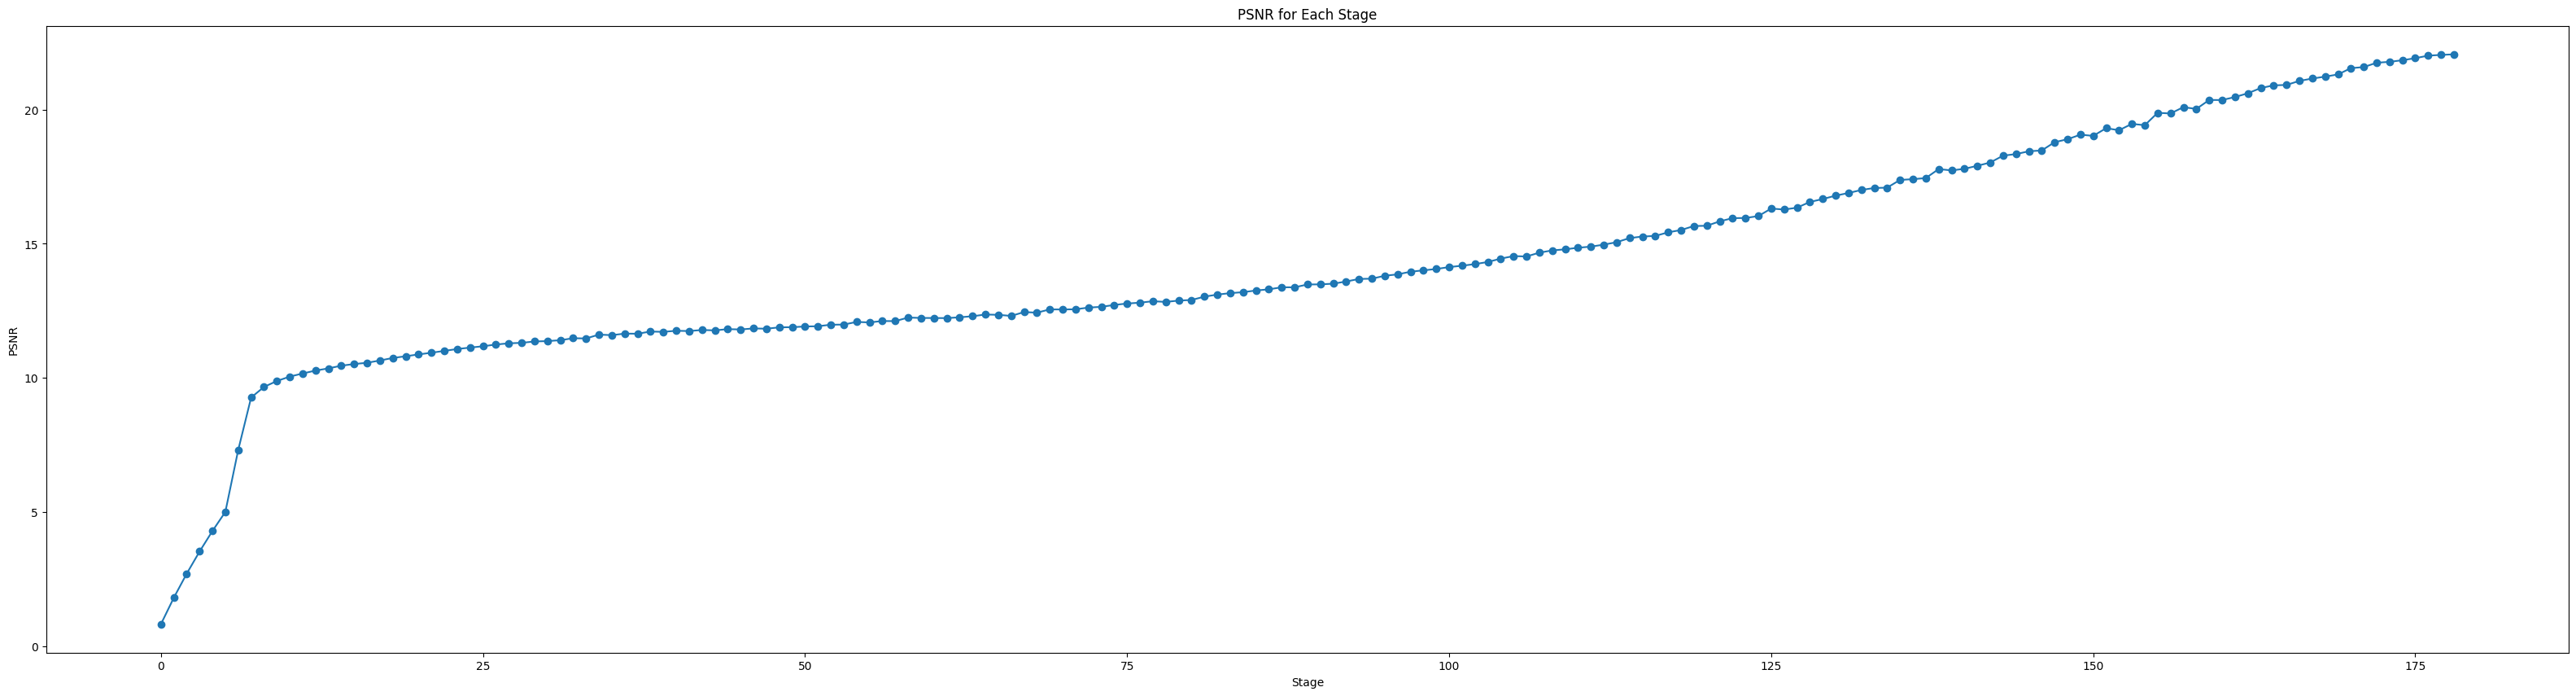

In [14]:
fig1, axis1 = plt.subplots(1, 1, figsize=(40, 10))
axis1.plot(output_psnr, marker = 'o')
axis1.set_title('PSNR for Each Stage')
plt.xlabel("Stage")
plt.ylabel("PSNR")

In [15]:
# Calculate PSNR for output image and original image
original_img = (img - img.min()) / (img.max() - img.min())
compare_psnr(torch_to_numpy(output_images[-1]), original_img, data_range=original_img.max())

21.046787776254064